In [74]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [2]:
x = ["which book is this", "this is book and this is math"]

# I. Fundamental of TF-IDF

## 1. Implementing with CountVectorizer()

In [9]:
cv = CountVectorizer()
count = cv.fit_transform(x)

print(count.toarray())
print(cv.get_feature_names_out())

[[0 1 1 0 1 1]
 [1 1 2 1 2 0]]
['and' 'book' 'is' 'math' 'this' 'which']


In [16]:
bow = pd.DataFrame(count.toarray(), columns=cv.get_feature_names_out())
print("After apply transform to x: \n", bow)
print("Shape of bag of words: ", bow.shape)

After apply transform to x: 
    and  book  is  math  this  which
0    0     1   1     0     1      1
1    1     1   2     1     2      0
Shape of bag of words:  (2, 6)


In [60]:
tf = bow.copy().astype(float)
tf = tf.div(tf.sum(axis=1), axis=0)
print("Term Frequency: ")
print(tf)
print()

bow_count = (bow > 0).astype(int)
bow_count = bow_count.sum(axis=0)
idf = np.log((1 + len(bow)) / (1 + bow_count)) + 1
print("Inverse Document Frequency: ")
print(idf)
print()

tf_idf = tf.multiply(idf, axis=1)
print("TF-IDF: ")
print(tf_idf)

Term Frequency: 
        and      book        is      math      this  which
0  0.000000  0.250000  0.250000  0.000000  0.250000   0.25
1  0.142857  0.142857  0.285714  0.142857  0.285714   0.00

Inverse Document Frequency: 
and      1.405465
book     1.000000
is       1.000000
math     1.405465
this     1.000000
which    1.405465
dtype: float64

TF-IDF: 
        and      book        is      math      this     which
0  0.000000  0.250000  0.250000  0.000000  0.250000  0.351366
1  0.200781  0.142857  0.285714  0.200781  0.285714  0.000000


## 2. Using TFIDFVectorizer

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
tfidf =  TfidfVectorizer()
# Raw counts, L2-normalization

X = tfidf.fit_transform(x)
print("TF-IDF matrix:\n", X.toarray())
print("Feature names:\n", tfidf.get_feature_names_out())
print("IDF values:\n", tfidf.idf_)

TF-IDF matrix:
 [[0.         0.44832087 0.44832087 0.         0.44832087 0.63009934]
 [0.39054766 0.27787788 0.55575576 0.39054766 0.55575576 0.        ]]
Feature names:
 ['and' 'book' 'is' 'math' 'this' 'which']
IDF values:
 [1.40546511 1.         1.         1.40546511 1.         1.40546511]


# II. Spam Text Classification

## 1. Load Spam Dataset

In [76]:
df = pd.read_csv('spam.csv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [78]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

## 2. Balance Dataset

In [83]:
ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']
ham_sample = ham.sample(spam.shape[0])
data = pd.concat([ham_sample, spam], ignore_index=True)
data.sample(5)

,label,message,length,punct
483,ham,"Pity, * was in mood for that. So...any other s...",57,7
747,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
1028,spam,Great News! Call FREEFONE 08006344447 to claim...,118,3
1296,spam,Orange brings you ringtones from all time Char...,154,5
706,ham,That seems unnecessarily hostile,32,0


In [84]:
data.shape

(1494, 4)

## 3. EDA

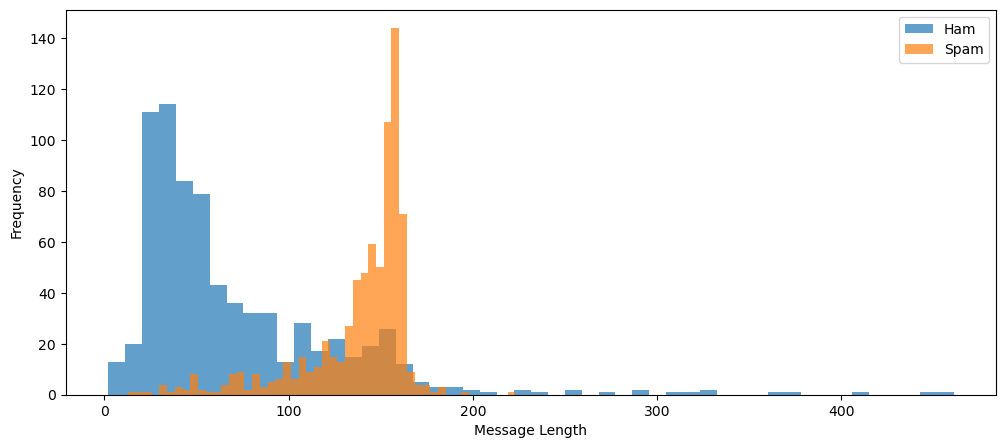

In [86]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(ham_sample['length'], bins=50, alpha=0.7, label='Ham')
ax.hist(spam['length'], bins=50, alpha=0.7, label='Spam')
ax.set_xlabel('Message Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()
plt.close(fig)

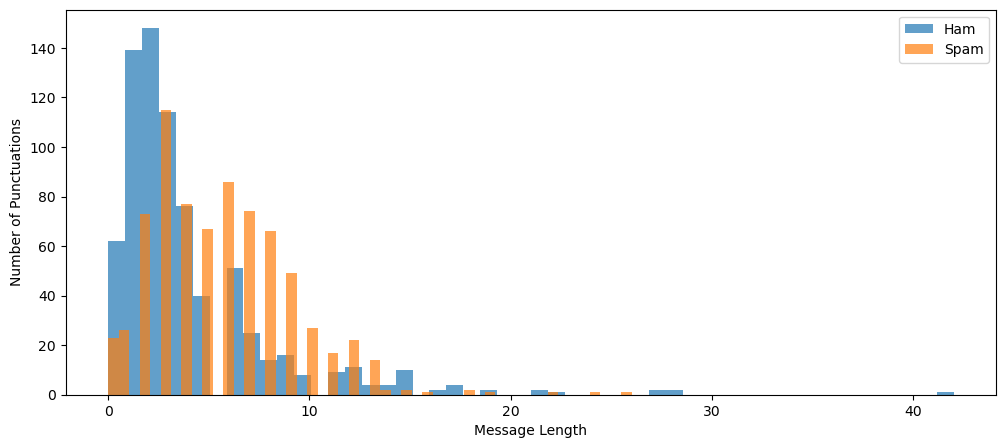

In [87]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(ham_sample['punct'], bins=50, alpha=0.7, label='Ham')
ax.hist(spam['punct'], bins=50, alpha=0.7, label='Spam')
ax.set_xlabel('Message Length')
ax.set_ylabel('Number of Punctuations')
ax.legend()
plt.show()
plt.close(fig)

## 4. Building Embedding Data

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['message'])
X = X.toarray()

In [92]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42, stratify=data['label'])

In [94]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1195, 4583), (299, 4583), (1195,), (299,))

## 5. Building Classification Models

### 5.1 Random Forest

In [95]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [96]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [97]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.93      1.00      0.96       150
        spam       1.00      0.92      0.96       149

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

Confusion Matrix:
 [[150   0]
 [ 12 137]]


### 5.2 SVM

In [99]:
svm = SVC(C=1000, gamma='auto')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.93      0.97      0.95       150
        spam       0.97      0.93      0.95       149

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299

Confusion Matrix:
 [[146   4]
 [ 11 138]]


# III. Test with Real Data

In [100]:
def predict(x):
    x_tfidf = tfidf.transform([x])
    x_tfidf = x_tfidf.toarray()
    pred = rf.predict(x_tfidf)
    return pred[0]

In [101]:
predict("Congratulations! You've won a free ticket to Bahamas. Call now!")

'spam'

In [102]:
predict('hey, whassup')

'ham'